# Demonstration for DEFRA

__Description & purpose__: This Notebook is designed to showcase the initial functionality of the Earth Observation Data Hub. It provides a snapshot of the Hub, the `pyeodh` API client and the various datasets as of September 2024. The Notebook "user" would like to understand more about the satellite data available for their test areas. This user is also interested in obtaining a cloud free dataset and ultimately creating a data cube. The Notebook is designed in such a way that it can be run on the EODH AppHub (Notebook Service) or from a local environment.  

__Author(s)__: Alastair Graham, Dusan Figala, Phil Kershaw

__Date created__: 2024-09-05

__Date last modified__: 2024-09-18

__Licence__: This notebook is licensed under [Creative Commons Attribution-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-sa/4.0/).  The code is released using the [BSD-2-Clause](https://www.tldrlegal.com/license/bsd-2-clause-license-freebsd) license.


<span style="font-size:0.75em;">
Copyright (c) , All rights reserved.</span>

<span style="font-size:0.75em;">
Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:</span>

<span style="font-size:0.75em;">
Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.</span>

__Links__:
* Oxidian: https://www.oxidian.com/
* CEDA: https://www.ceda.ac.uk/ 
* EO Data Hub: https://eodatahub.org.uk/

# What is the EODH?
The Earth Observation Data Hub is:

"A UK Pathfinder project delivering access to Earth Observation (EO) data for effective decisionmaking across government, business and academia. The Earth Observation DataHub (EODH) brings together an expert project delivery team and industrial partners in an ambitious project... Users of the Hub will be able to explore areas of interest in the UK and across the globe... It will also enable selected users to support their own analyses, services and tools using the Hub’s workflow and compute environments."

More details can be found online at https://eodatahub.org.uk/

Components of the Hub include:
* A Resource Catalogue - a STAC compliant catalogue of open and commercial satellite imagery, climate data, model results, workflows and more
* A Workflow Runner - a dedicated piece of cloud infrastructure to horizontally scale workflow requirements
* A Web Presence - an intuitive user interface to allow account management, data discovery and mapping
* An App Hub - a science portal providing access to a Jupyter lab environment 

### Presentation set up

The following cell only needs to be run on the EODH AppHub.  If you have a local Python environment running, please install the required packages as you would normally.

In [ ]:
# If needed you can install a package in the current AppHub Jupyter environment using pip
# For instance, we will need the following libraries
import sys
!{sys.executable} -m pip install --upgrade pyeodh pandas matplotlib numpy pillow folium

# EODH: it's data discovery

There are a number of API endpoints that are exposed by the EODH. Oxidian have developed a Python API Client, `pyeodh`, that makes the Hub's API endpoints available to Python users. `pyeodh` is available on PyPi (https://pypi.org/project/pyeodh/) and can be installed using `pip`. Documentation for the API Client is available at: https://pyeodh.readthedocs.io/en/latest/api.html

We will use `pyeodh` throughout this presentation.

In [1]:
# Imports
import pyeodh

import os

import shapely 
import geopandas as gpd
import folium
from localtileserver import TileClient
import dask.distributed
import folium

import requests
from requests import HTTPError

import urllib.request
from io import BytesIO 
from PIL import Image
from IPython.display import display
from pystac_client import Client
from odc.stac import configure_rio, stac_load # the data cube bit

#import shapely.geometry

Having imported the necessary libraries the next task is to set up the locations of the areas of interest.
Having created the AOI points the user needs to connect to the Resource Catalogue so that they can start to find some data.

In [2]:
# Areas of Interest
rut_pnt = shapely.Point(-0.683261054299237, 52.672193937442586) # a site near Rutland
thet_pnt = shapely.Point(0.6715892933273722, 52.414471075812315) # a site near Thetford

In [ ]:
# Optional cell
# If you want to see these points on a map run this cell

# Create a map (m) centered between the two points
center_lat = (rut_pnt.y + thet_pnt.y) / 2
center_lon = (rut_pnt.x + thet_pnt.x) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=8)

# Add markers for each point
folium.Marker([rut_pnt.y, rut_pnt.x], popup="Rutland Site", icon=folium.Icon(color="blue")).add_to(m)
folium.Marker([thet_pnt.y, thet_pnt.x], popup="Thetford Site", icon=folium.Icon(color="green")).add_to(m)

# Step 4: Display the map
m


In [3]:
# Connect to the Hub
client = pyeodh.Client().get_catalog_service()

# Print a list of the collections held in the Resource Catalogue (their id and description).
# As the Resource Catalogue fills and development continues, the number of collections and the richness of their descriptions will increase
for collect in client.get_collections():
    print(f"{collect.id}: {collect.description}")

cmip6: CMIP6
cordex: CORDEX
ukcp: UKCP
defra-airbus: A collection of Airbus data for the DEFRA use case.
defra-planet: A collection of Planet data for the DEFRA use case.
airbus_sar_data: The German TerraSAR-X / TanDEM-X satellite formation and the Spanish PAZ satellite (managed by Hisdesat Servicios Estratégicos S.A.) are being operated in the same orbit tube and feature identical ground swaths and imaging modes - allowing Airbus and Hisdesat to establish a unique commercial Radar Constellation. The satellites carry a high frequency X-band Synthetic Aperture Radar (SAR) sensor in order to acquire datasets ranging from very high-resolution imagery to wide area coverage.
airbus_data_example: Airbus data
sentinel2_ard: sentinel 2 ARD
sentinel1: Sentinel 1
naip: The [National Agriculture Imagery Program](https://www.fsa.usda.gov/programs-and-services/aerial-photography/imagery-programs/naip-imagery/) (NAIP) provides U.S.-wide, high-resolution aerial imagery, with four spectral bands (R, G

In [4]:
# The next thing to do is find some open data
# For this presentation we want to find Sentinel-2 analysis ready (ARD) imagery near Rutland

# First we just want to understand some of the parameters linked to the data collection
# We will just print the first 5 records and the dataset temporal extent   
sentinel2_ard = client.get_catalog("supported-datasets/ceda-stac-fastapi").get_collection('sentinel2_ard')
sentinel2_ard.get_items()

lim = 5
i = 0

for item in sentinel2_ard.get_items():
    if i < lim:
        print(item.id)
        i += 1

print('DATASET TEMPORAL EXTENT: ', [str(d) for d in sentinel2_ard.extent.temporal.intervals[0]])

neodc.sentinel_ard.data.sentinel_2.2023.11.21.S2B_20231121_latn536lonw0052_T30UUE_ORB123_20231121122846_utm30n_TM65
neodc.sentinel_ard.data.sentinel_2.2023.11.20.S2A_20231120_latn563lonw0037_T30VVH_ORB037_20231120132420_utm30n_osgb
neodc.sentinel_ard.data.sentinel_2.2023.11.20.S2A_20231120_latn546lonw0037_T30UVF_ORB037_20231120132420_utm30n_osgb
neodc.sentinel_ard.data.sentinel_2.2023.11.20.S2A_20231120_latn536lonw0007_T30UXE_ORB037_20231120132420_utm30n_osgb
neodc.sentinel_ard.data.sentinel_2.2023.11.20.S2A_20231120_latn528lonw0022_T30UWD_ORB037_20231120132420_utm30n_osgb
DATASET TEMPORAL EXTENT:  ['2023-01-01 11:14:51+00:00', '2023-11-01 11:43:49+00:00']


In [5]:
# To find out information about all the imagery in the collection then use this cell
# It undertakes a search for specific date ranges (November 2023) and limits the pagination return to 10
item_search = client.search(
    collections=['sentinel2_ard'],
    catalog_paths=["supported-datasets/ceda-stac-fastapi"],
    query=[
        'start_datetime>=2023-11-01',
        'end_datetime<=2023-11-30', 
    ],
    limit=10,
)

# The item id and start time of image capture can be printed
# If end time is also required, add the following code to the print statement: item.properties["end_datetime"]  
for item in item_search:
    print(item.id, item.properties["start_datetime"])

neodc.sentinel_ard.data.sentinel_2.2023.11.21.S2B_20231121_latn536lonw0052_T30UUE_ORB123_20231121122846_utm30n_TM65 2023-11-21T11:43:49+00:00
neodc.sentinel_ard.data.sentinel_2.2023.11.20.S2A_20231120_latn563lonw0037_T30VVH_ORB037_20231120132420_utm30n_osgb 2023-11-20T11:23:51+00:00
neodc.sentinel_ard.data.sentinel_2.2023.11.20.S2A_20231120_latn546lonw0037_T30UVF_ORB037_20231120132420_utm30n_osgb 2023-11-20T11:23:51+00:00
neodc.sentinel_ard.data.sentinel_2.2023.11.20.S2A_20231120_latn536lonw0007_T30UXE_ORB037_20231120132420_utm30n_osgb 2023-11-20T11:23:51+00:00
neodc.sentinel_ard.data.sentinel_2.2023.11.20.S2A_20231120_latn528lonw0022_T30UWD_ORB037_20231120132420_utm30n_osgb 2023-11-20T11:23:51+00:00
neodc.sentinel_ard.data.sentinel_2.2023.11.20.S2A_20231120_latn527lonw0007_T30UXD_ORB037_20231120132420_utm30n_osgb 2023-11-20T11:23:51+00:00
neodc.sentinel_ard.data.sentinel_2.2023.11.20.S2A_20231120_latn519lonw0037_T30UVC_ORB037_20231120132420_utm30n_osgb 2023-11-20T11:23:51+00:00
neodc.

In [6]:
# To find specific imagery for the Rutland site we need to add the intersects parameter. We set this to be our AOI point.
# We can also filter the search by cloud cover, in this case limiting our search to images with less than 50% cloud in them

items = client.search(
    collections=['sentinel2_ard'],
    catalog_paths=["supported-datasets/ceda-stac-fastapi"],
    intersects=rut_pnt,
    query=[
        'start_datetime>=2023-11-01',
        'end_datetime<=2023-11-30', 
        'Cloud Coverage Assessment<=50.0'
    ],
    limit=10,
)

# We can then count the number of items returned by the search 
print('Number of items found: ', items.total_count)

Number of items found:  2


In [7]:
# For the purposes of this presentation we will look at the second record ([1]) in more detail
# First we need to understand what information we can access

a = items[1].to_dict()
print(a.keys())

dict_keys(['type', 'stac_version', 'id', 'properties', 'geometry', 'links', 'assets', 'bbox', 'stac_extensions', 'collection'])


In [8]:
# It seems likely that the image data we want to access is stored under the 'assets' key. But what information is held in that? 
for key in (a['assets']):
    print(key)

cloud
cloud_probability
cog
metadata
saturated_pixels
thumbnail
topographic_shadow
valid_pixels


In [9]:
# Now we can get the link to each of the different assets
for key, value in items[1].assets.items():
    print(key, value.href)

cloud https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/17/S2A_20231117_latn527lonw0007_T30UXD_ORB137_20231117131218_utm30n_osgb_clouds.tif
cloud_probability https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/17/S2A_20231117_latn527lonw0007_T30UXD_ORB137_20231117131218_utm30n_osgb_clouds_prob.tif
cog https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/17/S2A_20231117_latn527lonw0007_T30UXD_ORB137_20231117131218_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.tif
metadata https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/17/S2A_20231117_latn527lonw0007_T30UXD_ORB137_20231117131218_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref_meta.xml
saturated_pixels https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/17/S2A_20231117_latn527lonw0007_T30UXD_ORB137_20231117131218_utm30n_osgb_sat.tif
thumbnail https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/17/S2A_20231117_latn527lonw0007_T30UXD_ORB137_20231117131218_utm3

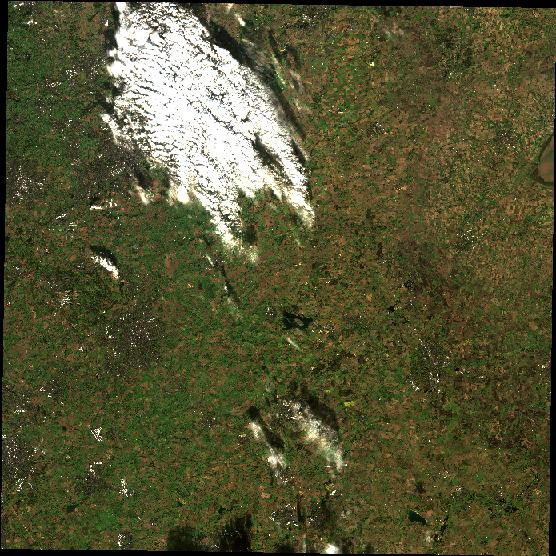

In [10]:
# We can use this information to view the image thumbnail

asset_dict = items[1].assets

# Get the url as a string
thumbnail_assets = [v for k, v in asset_dict.items() if 'thumbnail' in k]
thumbnail_url = thumbnail_assets[0].href

# Here we open the remote URL, read the data and dislay the thumbnail 
with urllib.request.urlopen(thumbnail_url) as url:
    img = Image.open(BytesIO(url.read()))

display(img)


This shows that we can relatively easily interrogate the Resource Catalogue and filter the results so that we can find the data we require in the EODH. With a bit of tweaking of the code the user could also generate a list of assets and accompanying URLs to the datasets (for this and other datasets). 

Now our use wants to see what commercial data exists for Thetford

In [12]:
# Find some commercial data

for collect in client.get_collections():
    if 'defra' in collect.id: 
        print(f"{collect.id}: {collect.description}")

defra-airbus: A collection of Airbus data for the DEFRA use case.
defra-planet: A collection of Planet data for the DEFRA use case.


In [29]:
# Let's search for information on the Planet holdings  
planet = client.get_catalog("supported-datasets/defra").get_collection('defra-planet')
planet.get_items()

lim = 5
i = 0

for item in planet.get_items():
    if i < lim:
        print(item.id)
        i += 1

print('PLANET DATASET TEMPORAL EXTENT: ', [str(d) for d in planet.extent.temporal.intervals[0]])



2024-08-23_strip_7527622_composite
2024-08-23_strip_7527462_composite
PLANET DATASET TEMPORAL EXTENT:  ['2024-08-23 11:09:19.358417+00:00', '2024-08-23 11:24:40.991786+00:00']


In [31]:
# To find specific imagery for the Thetford site we need to add the intersects parameter. We set this to be our AOI point.
items1 = client.search(
    collections=['defra-planet'],
    catalog_paths=["supported-datasets/defra"],
    intersects=thet_pnt,
    limit=10,
)

items2 = client.search(
    collections=['defra-airbus'],
    catalog_paths=["supported-datasets/defra"],
    intersects=thet_pnt,
    limit=10,
)

# We can then count the number of items returned by the search 
print('Number of Planet items found: ', items1.total_count)
print('Number of Airbus items found: ', items2.total_count)

Number of Planet items found:  1
Number of Airbus items found:  2


In [36]:
for key, value in items1[0].assets.items():
    print('Planet: ', key, value)

Planet:  data <Asset href=2024-08-23_strip_7527462_composite_file_format.tif>
Planet:  udm2 <Asset href=2024-08-23_strip_7527462_composite_udm2_file_format.tif>


# TODO!!!!
# DISPLAY AN IMAGE

# EODH: it's massive compute
The EODH compute architecture is built around a new OGC standard called EO Application Packages (EOAP). These are complex constructions of code and data, and at their core is the concept of a Common Workflow Language (CWL) workflow. To run CWL workflows you need a CWL runner, and the EODH Workflow Runner provides that. The EOAPs require a workflow description in CWL, a Docker container, bespoke scripts and links to the data. In the case of EODH, the data inputs and outputs are to be provided as STAC catalogues. Oxidian, as part of our work developing integrations for the Hub, have created a generator tool `eoap-gen` that abstracts away much of the complexity (check out the training materials repository and website for more details).   

Oxidian have also developed a QGIS plugin to allow desktop users to discover, parameterise and execute workflows on the Hub.

In [38]:
# First the user needs to connect to the Workflow Runner
# Currently this is done by obtaining a user account and API key from the core development team. Here, those details have been saved in secrets.txt

with open('secrets.txt', 'r') as file:
    lines = file.readlines()
    username = lines[0].strip().split('=')[1].strip('"')
    token = lines[1].strip().split('=')[1].strip('"')

clientwfr = pyeodh.Client(username=username, token=token, s3_token=token)
wfr = clientwfr.get_ades()

Our user wants to know what workflows they have access to in their workspace on the Hub.

In [39]:
# List the workflows available in the user workspace
for p in wfr.get_processes():
    print(p.id)

display
echo
convert-img


As development continues the number of demonstration workflows available to users will increase. With uptake of the generator tool users will also be able to create their own bespoke workflows. In time, the Hub will contain organisational accounts and the ability to share workflow files.

Our user wants to deploy a workflow that they have found online. They can do so for compliant CWL files by submitting the URl. 

In [40]:
# Deploy a workflow using a URL to a .cwl file hosted online
convert_url_proc = wfr.deploy_process(
    cwl_url="https://raw.githubusercontent.com/EOEPCA/deployment-guide/main/deploy/samples/requests/processing/convert-url-app.cwl"
)
print(convert_url_proc.id, convert_url_proc.description, ": Deployed")
print('')
# List the available workflows
for p in wfr.get_processes():
    print(p.id)

convert-url Convert URL : Deployed

display
echo
convert-img
convert-url


In [41]:
# If a user wants to tidy their workspace or no longer wants access to a workflow they can remove it
try:
    wfr.get_process("convert-url").delete()
    print("Process removed")
except HTTPError:
    print("Process not found")

Process removed


The user is interested in the ARD files, but they are too large for the task that they want to undertake. The workflow file linked to [here](https://github.com/figi44/eoap/blob/main/resize-collection.cwl) takes a series of data from the Sentinel 2 ARD collection and resizes the imagery using gdal_translate. The CWL file needs to be submitted to the Workflow Runner and parameterised, before it can then be run.  

In [43]:
# Deploy the workflow
# Remove an existing nstance of the workflow
try:
    wfr.get_process("convert-img").delete()
    print("Process removed")
except HTTPError:
    print("Process not found")

# Deploy from a URL to a .cwl file hosted online
#img_proc = wfr.deploy_process(cwl_yaml=cwl_yaml)
img_proc = wfr.deploy_process(cwl_url='https://raw.githubusercontent.com/ajgwords/eodh-tests/main/resize-col.cwl')

print(img_proc.id, img_proc.description, ": Deployed")
print('')
# List the available workflows
for p in wfr.get_processes():
    print(p.id)

Process not found
resize-col Resize collection cogs : Deployed

display
echo
resize-col


Once the CWL file has been submitted then it is possible for users with suitable permissions to also view the list of available workflows through the QGIS plugin.

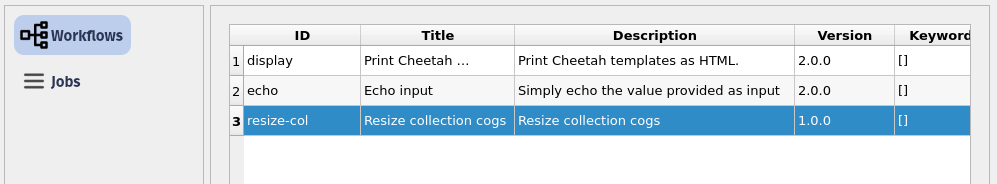

The user can choose and parameterise a workflow using the QGIS plugin as shown in this screenshot. A series of defaults are provided with all workflow files so a user can run the workflow straight away using those. To do so in code, the user provides an empty dictionary. 

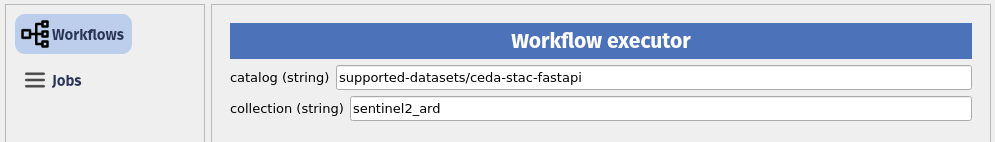

In [44]:
# Run the workflow using the defaults
pyeodh.set_log_level(10) # set the logging to be verbose

resize_job = img_proc.execute(
    {
    }
)

print(resize_job.id, resize_job.status, resize_job.message)


DEBUG: _request_json_raw received {'self': <pyeodh.client.Client object at 0x7d35e47e45c0>, 'method': 'POST', 'url': 'https://test.eodatahub.org.uk/ades/ajgwords/ogc-api/processes/resize-col/execution', 'headers': {'Prefer': 'respond-async'}, 'params': None, 'data': {'inputs': {'workspace': 'ajgwords'}}, 'encode': <function _encode_json at 0x7d3635f30540>}
DEBUG: Making request: POST https://test.eodatahub.org.uk/ades/ajgwords/ogc-api/processes/resize-col/execution
       headers: {'Prefer': 'respond-async', 'Content-Type': 'application/json'}
       params: None
       body: {"inputs": {"workspace": "ajgwords"}}
DEBUG: Received response 201
       headers: {'Content-Type': 'application/json;charset=UTF-8', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Server': 'nginx/1.27.0', 'Date': 'Wed, 18 Sep 2024 14:05:46 GMT', 'x-powered-by': 'ZOO-Project-DRU', 'x-also-powered-by': 'jwt.securityIn', 'x-also-also-powered-by': 'dru.securityIn', 'preference-applied': 'respond-async',

19efd624-75c7-11ef-9849-4e9264aaf6f3 running ZOO-Kernel accepted to run your service!


In [45]:
resize_job.refresh()
print(resize_job.id, resize_job.status, resize_job.message)

DEBUG: _request_json_raw received {'self': <pyeodh.client.Client object at 0x7d35e47e45c0>, 'method': 'GET', 'url': 'https://test.eodatahub.org.uk/ades/ajgwords/ogc-api/jobs/19efd624-75c7-11ef-9849-4e9264aaf6f3', 'headers': None, 'params': None, 'data': None, 'encode': <function _encode_json at 0x7d3635f30540>}
DEBUG: Making request: GET https://test.eodatahub.org.uk/ades/ajgwords/ogc-api/jobs/19efd624-75c7-11ef-9849-4e9264aaf6f3
       headers: {}
       params: None
       body: None
DEBUG: Received response 200
       headers: {'Content-Type': 'application/json;charset=UTF-8', 'Content-Length': '507', 'Connection': 'keep-alive', 'Server': 'nginx/1.27.0', 'Date': 'Wed, 18 Sep 2024 14:05:54 GMT', 'Access-Control-Allow-Origin': '*', 'Access-Control-Allow-Credentials': 'true', 'Access-Control-Allow-Methods': 'GET, PUT, POST, DELETE, PATCH, OPTIONS', 'Access-Control-Allow-Headers': 'DNT,User-Agent,X-Requested-With,If-Modified-Since,Cache-Control,Content-Type,Range,Authorization,Prefer', 

19efd624-75c7-11ef-9849-4e9264aaf6f3 running processing environment created, preparing execution


The outputs above show the status of the running job: `"status": "running"`. The job status can also be monitored using the QGIS plugin.

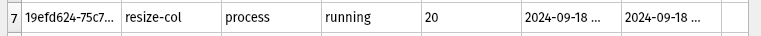

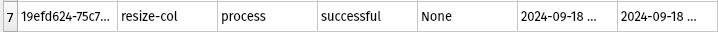

The outputs are accessible and loadable from the QGIS plugin.

Original image: 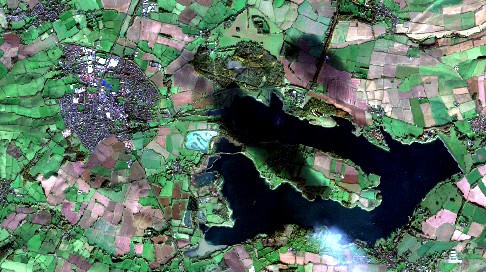  Resampled image: 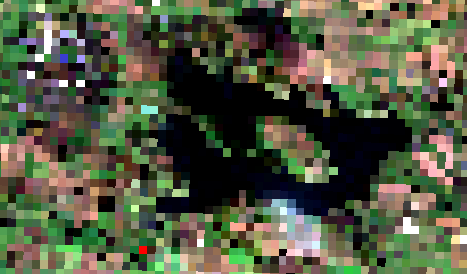

# EODH: it's data analysis
Notebook service can be used with pyeodh and other libraries installed using pip to analyse data and outputs

In [49]:
from localtileserver import TileClient

#data_url = 'https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/17/S2A_20231117_latn527lonw0007_T30UXD_ORB137_20231117131218_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.tif'
map = TileClient('data/S2A_clip_rend.tif')
#map = TileClient(data_url)
map

/home/al/miniforge3/envs/eodh/lib/python3.12/site-packages/rio_tiler/io/rasterio.py:130: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


Map(center=[52.661894000000004, -0.650007], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_i…

In [ ]:
print(a['assets']['cog']['href'])
print()
for key in (a['assets']['cog']['eo:bands']):
    print(key)

s2url = (a['assets']['cog']['href'])

In [8]:

# Step 1: Define the URL of the Cloud Optimized GeoTIFF (COG)
cog_path = "https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/17/S2A_20231117_latn527lonw0007_T30UXD_ORB137_20231117131218_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.tif"

import rioxarray
import numpy as np
from shapely.geometry import box
import geopandas as gpd
from PIL import Image
import matplotlib.pyplot as plt


# Read the image as an xarray dataset
data = rioxarray.open_rasterio(cog_path)

# Step 2: Define the clipping area (bounding box) in the same CRS as the image
# Adjust the minx, miny, maxx, maxy to your area of interest
minx, miny, maxx, maxy = 481682, 296841, 512343, 313344  # Example bounds in UTM
bbox = box(minx, miny, maxx, maxy)

# Convert the bounding box into a GeoDataFrame
geo_df = gpd.GeoDataFrame({'geometry': [bbox]}, crs=data.rio.crs)

# Step 3: Clip the data using the bounding box (rioxarray will handle the masking)
clipped_data = data.rio.clip(geo_df.geometry.apply(lambda x: x.__geo_interface__), geo_df.crs)




In [ ]:
# Step 4: Select three bands for RGB visualization
# Assuming band 1 = Blue, band 2 = Green, band 3 = Red
# Check the specific band indexes based on your data
red_band = clipped_data.sel(band=3)  # Select the Red band (band index 3)
green_band = clipped_data.sel(band=2)  # Select the Green band (band index 2)
blue_band = clipped_data.sel(band=1)  # Select the Blue band (band index 1)

# Step 5: Normalize the bands for display (values between 0 and 255)
def normalize_band(band):
    band_min, band_max = band.min(), band.max()
    return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)

# Normalize the selected bands
red_norm = normalize_band(red_band)
green_norm = normalize_band(green_band)
blue_norm = normalize_band(blue_band)

# Step 6: Stack the three bands into an RGB image
rgb_image = np.dstack([red_norm, green_norm, blue_norm])

# Step 7: Convert the NumPy array to a PIL image
pil_image = Image.fromarray(rgb_image)

# Step 8: Display the image using PIL or matplotlib
pil_image.show()

# Alternatively, display with matplotlib
plt.imshow(rgb_image)
plt.title("Clipped RGB Satellite Image")
plt.axis('off')
plt.show()


### Towards a data cube?

Following 
https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-e84-aws.html

In [50]:



def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

In [51]:
# FIND STAC ITEMS
#catalog = Client.open("https://earth-search.aws.element84.com/v1/")

url = "https://api.stac.ceda.ac.uk/"

client = Client.open(url)
for coll in client.get_collections():
    print(f"{coll.id}: {coll.description}")

cmip6: CMIP6
cordex: CORDEX
land_cover: land_cover
sentinel1: Sentinel 1
sentinel2_ard: sentinel 2 ARD
sst-cdrv3-collection: collection of EOCIS SST CDR V3
ukcp: UKCP


In [52]:
sentinel2_ard = client.get_collection('sentinel2_ard')

sentinel2_ard.get_items()

# check the spatial and temporal extent of the collection

print("spatial extent:", sentinel2_ard.extent.spatial.bboxes)
print("data range:", [str(d) for d in sentinel2_ard.extent.temporal.intervals[0]])



#items = list(query.items())
#print(f"Found: {len(items):d} datasets")

# Convert STAC items into a GeoJSON FeatureCollection
#stac_json = query.item_collection_as_dict()

spatial extent: [[-9.00034454651177, 49.48562028352171, 3.1494256015866995, 61.33444247301668]]
data range: ['2023-01-01 11:14:51+00:00', '2023-11-01 11:43:49+00:00']


In [56]:
# SEARCH
item_search = client.search(
    collections=['sentinel2_ard'],
    query=[
        'start_datetime>=2023-01-01',
        'end_datetime<=2023-02-28', 
    ],
    max_items=100,
)


In [57]:
items = list(item_search.items())
len(items)

100

In [58]:
#from shapely import Point
#point = Point(-1.3144835766058023, 51.57555380377267) # Atlas building at RAL

item_search = client.search(
    collections=['sentinel2_ard'],
    intersects=rut_pnt,
    query=[
        'start_datetime>=2023-01-01',
        'end_datetime<=2023-02-28', 
      ],
    max_items=10,
)

items = list(item_search.items())
items

[<Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.25.S2B_20230225_lat53lon071_T30UXD_ORB137_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.23.S2A_20230223_lat53lon071_T30UXD_ORB037_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.20.S2A_20230220_lat53lon071_T30UXD_ORB137_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.15.S2B_20230215_lat53lon071_T30UXD_ORB137_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.13.S2A_20230213_lat53lon071_T30UXD_ORB037_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.08.S2B_20230208_lat53lon071_T30UXD_ORB037_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.01.31.S2A_20230131_lat53lon071_T30UXD_ORB137_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.01.29.S2B_20230129_lat53lon071_T30UXD_ORB037_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.01.26.S2B_20230126_lat53lon071_T30UXD_ORB137_utm30n_osgb>,
 <Item id=neodc.sen

In [ ]:
items[0].to_dict()

In [ ]:
item_search = client.search(
    collections=['sentinel2_ard'],
    intersects=point,
    query=[
        'start_datetime>=2023-01-01',
        'end_datetime<=2023-02-28', 
        'eo:cloud_cover<=50.0'
      ],
    max_items=10,
)

items = list(item_search.items())
items

In [59]:
items[0].to_dict()

{'type': 'Feature',
 'stac_version': '1.0.0',
 'id': 'neodc.sentinel_ard.data.sentinel_2.2023.02.25.S2B_20230225_lat53lon071_T30UXD_ORB137_utm30n_osgb',
 'properties': {'file_count': 7,
  'start_datetime': '2023-02-25T11:09:39Z',
  'end_datetime': '2023-02-25T11:09:39Z',
  'NSSDC Identifier': '2015-000A',
  'created': '2024-02-07T11:36:34.672255Z',
  'Instrument Family Name': 'Multi-Spectral Instrument',
  'Platform Number': '2B',
  'Datatake Type': 'INS-NOBS',
  'esa_file_name': 'S2B_MSIL1C_20230225T110939_N0509_R137_T30UXD_20230225T115203',
  'Ground Tracking Direction': 'descending',
  'datetime': '2023-02-25T11:09:39Z',
  'instance_id': 'neodc.sentinel_ard.data.sentinel_2.2023.02.25.S2B_20230225_lat53lon071_T30UXD_ORB137_utm30n_osgb',
  'size': 1960567691,
  'Product Type': 'S2MSI1C',
  'Instrument Family Name Abbreviation': 'MSI',
  'Start Orbit Number': '031194',
  'eo:cloud_cover': '84.3860969273493',
  'Start Relative Orbit Number': '137',
  'updated': '2024-02-07T11:36:34.6722

In [60]:
for key, value in items[1].assets.items():
    print(key, value.href)

cloud https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/02/23/S2A_20230223_lat53lon071_T30UXD_ORB037_utm30n_osgb_clouds.tif
metadata https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/02/23/S2A_20230223_lat53lon071_T30UXD_ORB037_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref_meta.xml
thumbnail https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/02/23/S2A_20230223_lat53lon071_T30UXD_ORB037_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref_thumbnail.jpg
topographic_shadow https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/02/23/S2A_20230223_lat53lon071_T30UXD_ORB037_utm30n_osgb_toposhad.tif
cog https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/02/23/S2A_20230223_lat53lon071_T30UXD_ORB037_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.tif
valid_pixels https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/02/23/S2A_20230223_lat53lon071_T30UXD_ORB037_utm30n_osgb_valid.tif
saturated_pixels https://dap.ceda.ac.uk/neodc/sentinel_ard/data/s

In [62]:
# SET UP DASK CLIENT

client3 = dask.distributed.Client()
configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client) # sets up gdal for cloud use
display(client3)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 15.48 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34791,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 15.48 GiB
Comm: tcp://127.0.0.1:36473,Total threads: 1
Dashboard: http://127.0.0.1:36613/status,Memory: 3.87 GiB
Nanny: tcp://127.0.0.1:34453,


In [63]:
print(f"Found: {len(items):d} datasets")

# Convert STAC items into a GeoJSON FeatureCollection
stac_json = item_search.item_collection_as_dict()

Found: 10 datasets


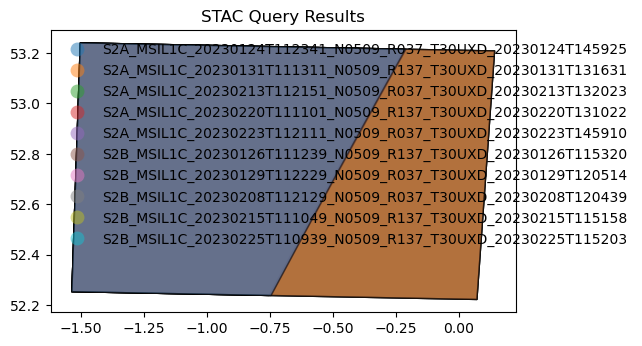

In [64]:
# REVIEW SEARCH RESULTS
# MAYBE DELETE

gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")

# Compute granule id from components
#gdf["granule"] = (
#    gdf["esa_file_name"].apply(lambda x: f"{x:02d}")
#    + gdf["mgrs:latitude_band"]
#    + gdf["mgrs:grid_square"]
#)

fig = gdf.plot(
    "esa_file_name",
    edgecolor="black",
    categorical=True,
    aspect="equal",
    alpha=0.5,
    figsize=(6, 12),
    legend=True,
    legend_kwds={"loc": "upper left", "frameon": False, "ncol": 1},
)
_ = fig.set_title("STAC Query Results")

In [68]:
# PLOT THE SAME, but using FOLIUM

# https://github.com/python-visualization/folium/issues/1501
#from branca.element import Figure

#import folium
f = folium.Figure(width=600, height=400)
m = folium.Map(location=[52, 2], zoom_start=5).add_to(f)





#fig = Figure(width="400px", height="500px")
#map1 = folium.Map()
#fig.add_child(map1)

#folium.GeoJson(
#    shapely.geometry.box(*bbox),
#    style_function=lambda x: dict(fill=False, weight=1, opacity=0.7, color="olive"),
#    name="Query",
#).add_to(m)


gdf.explore(
    "esa_file_name",
    categorical=True,
    tooltip=[
        "esa_file_name",
        "datetime",
        "eo:cloud_cover",
    ],
    popup=False,
    legend=False,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="STAC",
    m=m,
)

#map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))
#display(fig)

In [69]:
# CONSTRUCT DASK DATASET
# Note: there are 9 STAC Items on input, and only one timeslice on output. 
# Due to groupby="solar_day" (all items that occured on the same day added to one image plane).

# Since we will plot it on a map we need to use `EPSG:3857` projection
crs = "epsg:3857"
zoom = 2**5  # overview level 5

#xx = stac_load(
#    items,
#    bands=("B04", "B03", "B02"),
#    crs=crs,
#    resolution=10 * zoom)#,
#    chunks={},  # <-- use Dask
#    groupby="solar_day",
#)
#display(xx)


#xx = stac_load(
#    items,
#    chunks={"x": 2048, "y": 2048},
#    patch_url=pc.sign,
#    resolution=resolution,
#    # force dtype and nodata
#    dtype="uint16",
#    nodata=0,
#)

xx = stac_load(
    items,
    crs=crs,
    resolution=10 * zoom,
    chunks={"x": 2048, "y": 2048},  # <-- use Dask
)

print(f"Bands: {','.join(list(xx.data_vars))}")
display(xx)

Bands: cloud,thumbnail,topographic_shadow,cog,valid_pixels,saturated_pixels


<xarray.Dataset> Size: 82MB
Dimensions:             (y: 586, x: 584, time: 10)
Coordinates:
  * y                   (y) float64 5kB 7.028e+06 7.027e+06 ... 6.84e+06
  * x                   (x) float64 5kB -1.707e+05 -1.704e+05 ... 1.584e+04
    spatial_ref         int32 4B 3857
  * time                (time) datetime64[ns] 80B 2023-01-24T11:23:41 ... 202...
Data variables:
    cloud               (time, y, x) float32 14MB dask.array<chunksize=(1, 586, 584), meta=np.ndarray>
    thumbnail           (time, y, x) float32 14MB dask.array<chunksize=(1, 586, 584), meta=np.ndarray>
    topographic_shadow  (time, y, x) float32 14MB dask.array<chunksize=(1, 586, 584), meta=np.ndarray>
    cog                 (time, y, x) float32 14MB dask.array<chunksize=(1, 586, 584), meta=np.ndarray>
    valid_pixels        (time, y, x) float32 14MB dask.array<chunksize=(1, 586, 584), meta=np.ndarray>
    saturated_pixels    (time, y, x) float32 14MB dask.array<chunksize=(1, 586, 584), meta=np.ndarray>

In [ ]:
# DATA FOOTPRINT
#xx.odc.geobox

# TEST
xx.data_vars[cog]

In [ ]:
%%time
xx = xx.compute() # LOAD INTO LOCAL MEMORY